In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cPickle
import matplotlib.pyplot as plt
import os

from scipy.interpolate import pchip_interpolate
from scipy.signal import savgol_filter
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz

from bokeh.layouts import gridplot, column
from bokeh.plotting import figure, show, output_file
from bokeh.models import LinearAxis, Range1d
from bokeh.io import export_png

import seaborn as sns

np.set_printoptions(threshold=np.inf)

In [2]:
def jump_stitcher_anyMetric(incorrectVar, plot_flag):
    incorrectVar_diff = np.diff(incorrectVar)
    if incorrectVar_diff.size:
        diff_cutoff = np.percentile(incorrectVar_diff, 99)*10;

        out_of_bound_max_cutoff = np.percentile(incorrectVar,99)+(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2
        out_of_bound_min_cutoff = np.percentile(incorrectVar,1)-(np.percentile(incorrectVar,99)-np.percentile(incorrectVar,1))/2

        out_of_bound_index = np.where((incorrectVar>out_of_bound_max_cutoff) | (incorrectVar<out_of_bound_min_cutoff))
        out_of_bound_index = np.asarray(out_of_bound_index).flatten()
        discontinuity_index = np.array([-1])

        for i in range(0, len(incorrectVar_diff)):
            if np.abs(incorrectVar_diff[i]) > diff_cutoff:
                discontinuity_index = [discontinuity_index, (i-1), i, (i+1)]

        discontinuity_index = np.unique(discontinuity_index[discontinuity_index > 0])

        incorrectVar_nan = incorrectVar
        incorrectVar_nan[np.union1d(out_of_bound_index,discontinuity_index)] = np.nan
#         correctedVar = pd.Series(incorrectVar_nan).interpolate(method='pchip').ffill().bfill().as_matrix()
        correctedVar = pd.Series(incorrectVar_nan).interpolate(method='linear').as_matrix()        
#         correctedVar = pchip_interpolate(np.arange(0, len(incorrectVar_nan)), 
#                                          incorrectVar_nan, np.arange(0, len(incorrectVar_nan)))

        if plot_flag == 1:
            fig = plt.figure(figsize=(15, 8))
            plt.plot(np.arange(0, len(incorrectVar_nan[1000:1300])), incorrectVar_nan[1000:1300], color='k')
            plt.plot(np.arange(0, len(correctedVar[1000:1300])), 2+correctedVar[1000:1300], 'r')
            plt.show()
    else:
        correctedVar = incorrectVar

    return correctedVar

def calculateTailSpeed(tailposition, tf, history):
    tailSpeed = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    tailDisplacement = np.zeros((np.shape(tailposition)[0],), dtype=np.float)
    x = (tailposition[history:, 0] - tailposition[:-history, 0])**2
    y = (tailposition[history:, 1] - tailposition[:-history, 1])**2
    tailDisplacement[history:] = np.sqrt(x + y).copy()
    tailDisplacement = jump_stitcher_anyMetric(tailDisplacement, 0)
    tailSpeed[history:] = tailDisplacement[history:]/np.asarray(history*tf, dtype=np.float)
    tailSpeed = jump_stitcher_anyMetric(tailSpeed, 0)
    return tailSpeed

def smoothen_savgol(dat, window_size, polyOrder):
    dat_filt = savgol_filter(dat, window_size, polyOrder, mode='nearest')
    return dat_filt

def smoothen_convolve(dat, window):
    dat_filt = np.convolve(dat, window, mode='same')
    return dat_filt

def smoothen_gaussian(dat, window_size, sigma):
    b = gaussian(window_size, sigma)
    dat_filt = np.convolve(dat, b/b.sum(), mode='same')
    return dat_filt

def smoothen_gaussian_past(dat, window_size, sigma):
    b = gaussian(window_size, sigma)
    b = b/b.sum()
    b[window_size/2:] = 0
    dat_filt = np.convolve(dat, b, mode='same')
    return dat_filt

def get_stimulus_start_end(stimulus, baseline):
    stim_diff = stimulus - baseline
    stim_diff_2 = np.where(stim_diff > 0)[0]
    stim_diff_3 = np.where(np.ediff1d(stim_diff_2, to_begin=2000) > 1)[0]
    start = stim_diff_2[stim_diff_3]
    end = stim_diff_2[stim_diff_3-1]
    end = np.roll(end, -1)
    inter_start = np.hstack((0, end+5))
    inter_end = np.hstack((start-5, len(stimulus)))
    return start, end, inter_start, inter_end

def calculate_deltaF_by_F(before_val, after_val):
    return np.divide((after_val - before_val), before_val)

def convert_stimulus_percent_to_watts(stim):
    conv = lambda x: -6*(10**-5)*(x**3) - 0.0007*(x**2) + 0.9577*x - 1.4352
    stim_converted = conv(stim)
    return stim_converted

def convert_stimulus_percent_to_watts_blue(stim):
    conv = lambda x: 2*(10**-5)*(x**3) - 0.0047*(x**2) + 0.6156*x + 1.1742
    stim_converted = conv(stim)
    return stim_converted

def convert_stimulus_percent_to_watts_green(stim):
    conv = lambda x: 2*(10**-5)*(x**3) - 0.0054*(x**2) + 0.9895*x - 0.0785
    stim_converted = conv(stim)
    return stim_converted

In [3]:
## GtACR1 Experiment
start_frame = 250
end_frame = 35000
# experiment = '20180328_Cha_GtACR1_MidPoint_DoseResponse_1000micron_Blue'
# experiment = '20180328_OK371_GtACR1_MidPoint_DoseResponse_1000micron_Blue'

experiment = '20180418_221_Midpoint_1000micron_GreenLight'
# experiment = '20180418_Clh_221_Midpoint_1000micron_GreenLight'

## Load Data
load_data = 1
if load_data > 0:
    data_dir = os.path.join('../../../Data/', experiment, 'XML')
    kin_data_all = pd.read_csv(os.path.join(data_dir, 'kinData_xml.dat'), sep='\t', low_memory=False)
    fig_dir = os.path.join('../../../Figures/', experiment)
    if os.path.exists(fig_dir) != True:
        os.mkdir(fig_dir)

In [4]:
## Extract Head Angle
all_head_angle = []
all_head_angle = kin_data_all.loc[:,['headToBodyAngle', 'num', 'timeIndex']].pivot(index='num', columns='timeIndex').as_matrix()[:,start_frame:end_frame]

In [5]:
## Time per frame (in seconds)
tf = 0.008
total_time = np.arange(start_frame,end_frame)*tf
baseline = 0
stimulus = kin_data_all['intensity'][start_frame:end_frame].values
stimulus_watts = convert_stimulus_percent_to_watts_green(stimulus.copy())
stim_start, stim_end, stim_inter_start, stim_inter_end = get_stimulus_start_end(stimulus, baseline)

In [6]:
## Compute Mean Head Angle
mean_head_angle = np.nanmean(np.abs(all_head_angle), axis=0)

In [7]:
## Create a Trendline for Mean Tail Speed
window_size = 250
sigma = 125
mean_head_angle_trendline = smoothen_gaussian(mean_head_angle.copy(), window_size, sigma)

In [8]:
## Visualize Mean Tail Speed for All Larva
p1 = figure(x_axis_type="linear", title=experiment, 
            plot_width=1600, plot_height=600, y_range=(0, 90),
           toolbar_location="above")
p1.grid.grid_line_alpha=0.3

p1.xaxis.axis_label = 'Time (sec)'
p1.yaxis.axis_label = 'Absolute Head Angle (deg)'
p1.line(total_time, mean_head_angle, 
        legend='Absolute Head Angle', color='gray', line_alpha= 0.25)
p1.line(total_time, mean_head_angle_trendline, 
        legend='Absolute Head Angle Trendline', color='steelblue', line_width=3)

# Setting the second y axis range name and range
p1.extra_y_ranges = {"Stimulus": Range1d(start=-2, end=50)}
p1.add_layout(LinearAxis(y_range_name="Stimulus", axis_label="Stimulus W/m^2"), 'right')
p1.line(total_time, stimulus_watts, legend='Stimulus',
        y_range_name='Stimulus', color='navy')

p1.xaxis.axis_label_text_font_size = "18pt"
p1.yaxis.axis_label_text_font_size = "18pt"

p1.xaxis.major_label_text_font_size = "14pt"
p1.yaxis.major_label_text_font_size = "14pt"

p1.legend.location = "top_right"
output_file(os.path.join(fig_dir, "mean_head_angle_%s.html"%(experiment)), title=experiment)
export_png(p1, os.path.join(fig_dir, "mean_head_angle_%s.png"%(experiment)))
show(p1)  # open a browser

In [9]:
mean_head_angle_flash = np.zeros((np.shape(all_head_angle)[0], 2*len(stim_start)))
for i in range(0, np.shape(all_head_angle)[0]):
    for j in range(0, len(stim_start)):
        mean_head_angle_flash[i, 2*j] =  np.nanmean(np.abs(all_head_angle[i, stim_start[j]-380:stim_start[j]-5]))
        mean_head_angle_flash[i, 2*j+1] =  np.nanmean(np.abs(all_head_angle[i, stim_start[j]:stim_end[j]+500]))       

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [10]:
qmin = np.nanpercentile(mean_head_angle_flash, 0, axis=0)
q1 = np.nanpercentile(mean_head_angle_flash, 25, axis=0)
q2 = np.nanpercentile(mean_head_angle_flash, 50, axis=0)
q3 = np.nanpercentile(mean_head_angle_flash, 75, axis=0)
qmax = np.nanpercentile(mean_head_angle_flash, 100, axis=0)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
mean_of_means = np.nanmean(mean_head_angle_flash, axis=0)
std_of_means = np.nanstd(mean_head_angle_flash, axis=0)

upper = [min([x,y]) for (x,y) in zip(list(qmax), upper)]
lower = [max([x,y]) for (x,y) in zip(list(qmin), lower)]

In [11]:
cats = np.sort(np.hstack((np.arange(0, 3*12, 3), np.arange(1, 3*12, 3))))
p = figure(tools="save", plot_width=1200, plot_height=600, 
           x_range=(-1, max(cats)+1), title=experiment)

# stems
p.segment(cats, upper, cats, q3, line_color="black")
p.segment(cats, lower, cats, q1, line_color="black")

# # boxes
p.vbar(cats, 0.7, q2, q3, fill_color="gray", line_color="black")
p.vbar(cats, 0.7, q1, q2, fill_color="gray", line_color="black")

# whiskers (almost-0 height rects simpler than segments)
p.rect(cats, lower, 0.2, 0.01, line_color="black")
p.rect(cats, upper, 0.2, 0.01, line_color="black")

output_file(os.path.join(fig_dir, "boxplot_head_angle_%s.html"%(experiment)), title=experiment)

show(p)

In [12]:
mean_head_angle_flash_before = np.zeros((np.shape(all_head_angle)[0], len(stim_start)))
mean_head_angle_flash_after = np.zeros((np.shape(all_head_angle)[0], len(stim_start)))

mean_head_angle_flash_before = np.zeros((np.shape(all_head_angle)[0], len(stim_start)))
mean_head_angle_flash_after = np.zeros((np.shape(all_head_angle)[0], len(stim_start)))
for i in range(0, np.shape(all_head_angle)[0]):
    for j in range(0, len(stim_start)):
        mean_head_angle_flash_before[i, j] =  np.nanmean(np.abs(all_head_angle[i, stim_start[j]-380:stim_start[j]-5]), axis=0)
        mean_head_angle_flash_after[i, j] =  np.nanmean(np.abs(all_head_angle[i, stim_start[j]:stim_end[j]+500]), axis=0)

/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/ajinkyadeogade/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [13]:
step_dur_4 = np.arange(0, 12, 2)
step_dur_8 = step_dur_4 + 1

step_inten_4 = np.array([0, 1])
step_inten_8 = step_inten_4 + 2
step_inten_12 = step_inten_4 + 4
step_inten_16 = step_inten_4 + 6
step_inten_24 = step_inten_4 + 8
step_inten_32 = step_inten_4 + 10

In [14]:
mean_head_angle_before = pd.DataFrame(mean_head_angle_flash_before.T)
mean_head_angle_before['Flash Duration (sec)'] = 0
mean_head_angle_before['Flash Intensity (W/m^2)'] = 0
mean_head_angle_before['Condition'] = 'Before Flash' ## pre -> before

mean_head_angle_before.loc[step_dur_4, 'Flash Duration (sec)'] = 4
mean_head_angle_before.loc[step_dur_8, 'Flash Duration (sec)'] = 8

mean_head_angle_before.loc[step_inten_4, 'Flash Intensity (W/m^2)'] = 4
mean_head_angle_before.loc[step_inten_8, 'Flash Intensity (W/m^2)'] = 8
mean_head_angle_before.loc[step_inten_12, 'Flash Intensity (W/m^2)'] = 12
mean_head_angle_before.loc[step_inten_16, 'Flash Intensity (W/m^2)'] = 16
mean_head_angle_before.loc[step_inten_24, 'Flash Intensity (W/m^2)'] = 24
mean_head_angle_before.loc[step_inten_32, 'Flash Intensity (W/m^2)'] = 32

In [15]:
mean_head_angle_after = pd.DataFrame(mean_head_angle_flash_after.T)
mean_head_angle_after['Flash Duration (sec)'] = 0
mean_head_angle_after['Flash Intensity (W/m^2)'] = 0
mean_head_angle_after['Condition'] = 'After Flash' ## post -> after

mean_head_angle_after.loc[step_dur_4, 'Flash Duration (sec)'] = 4
mean_head_angle_after.loc[step_dur_8, 'Flash Duration (sec)'] = 8

mean_head_angle_after.loc[step_inten_4, 'Flash Intensity (W/m^2)'] = 4
mean_head_angle_after.loc[step_inten_8, 'Flash Intensity (W/m^2)'] = 8
mean_head_angle_after.loc[step_inten_12, 'Flash Intensity (W/m^2)'] = 12
mean_head_angle_after.loc[step_inten_16, 'Flash Intensity (W/m^2)'] = 16
mean_head_angle_after.loc[step_inten_24, 'Flash Intensity (W/m^2)'] = 24
mean_head_angle_after.loc[step_inten_32, 'Flash Intensity (W/m^2)'] = 32

In [16]:
mean_head_angle_before_after = pd.concat([mean_head_angle_before, mean_head_angle_after], axis=0)
mean_head_angle_before_after = mean_head_angle_before_after.melt(id_vars=['Flash Duration (sec)', 'Flash Intensity (W/m^2)', 'Condition'], value_name='Head Angle (deg)')
mean_head_angle_before_after.drop('variable', axis=1, inplace=True)

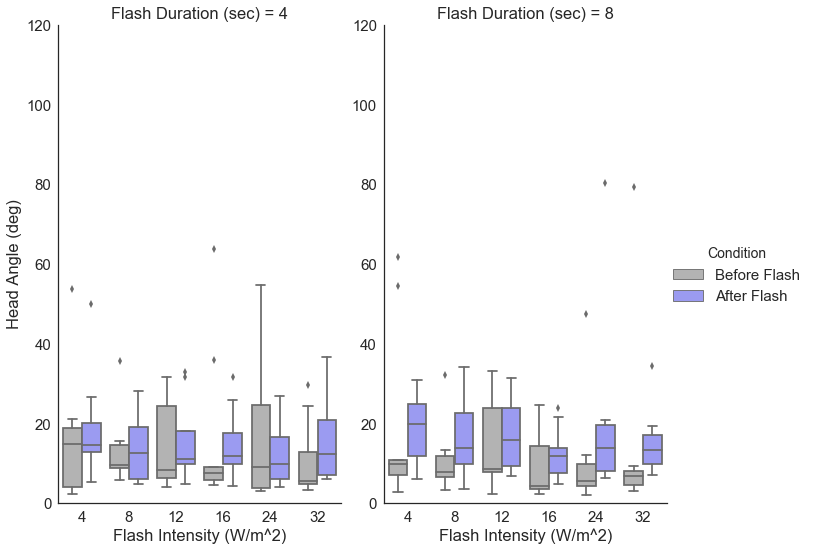

In [17]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
g = sns.factorplot(x="Flash Intensity (W/m^2)", y="Head Angle (deg)",
                   hue="Condition", col="Flash Duration (sec)",
                   data=mean_head_angle_before_after, kind="box", size=8, aspect=.6,
                   palette={"Before Flash": [0.7, 0.7, 0.7], "After Flash": [0.55, 0.55, 1]});
plt.ylim(0,120);
plt.savefig(os.path.join(fig_dir, "factor_plot_per_flash_duration_head_angle_%s.png"%(experiment)))

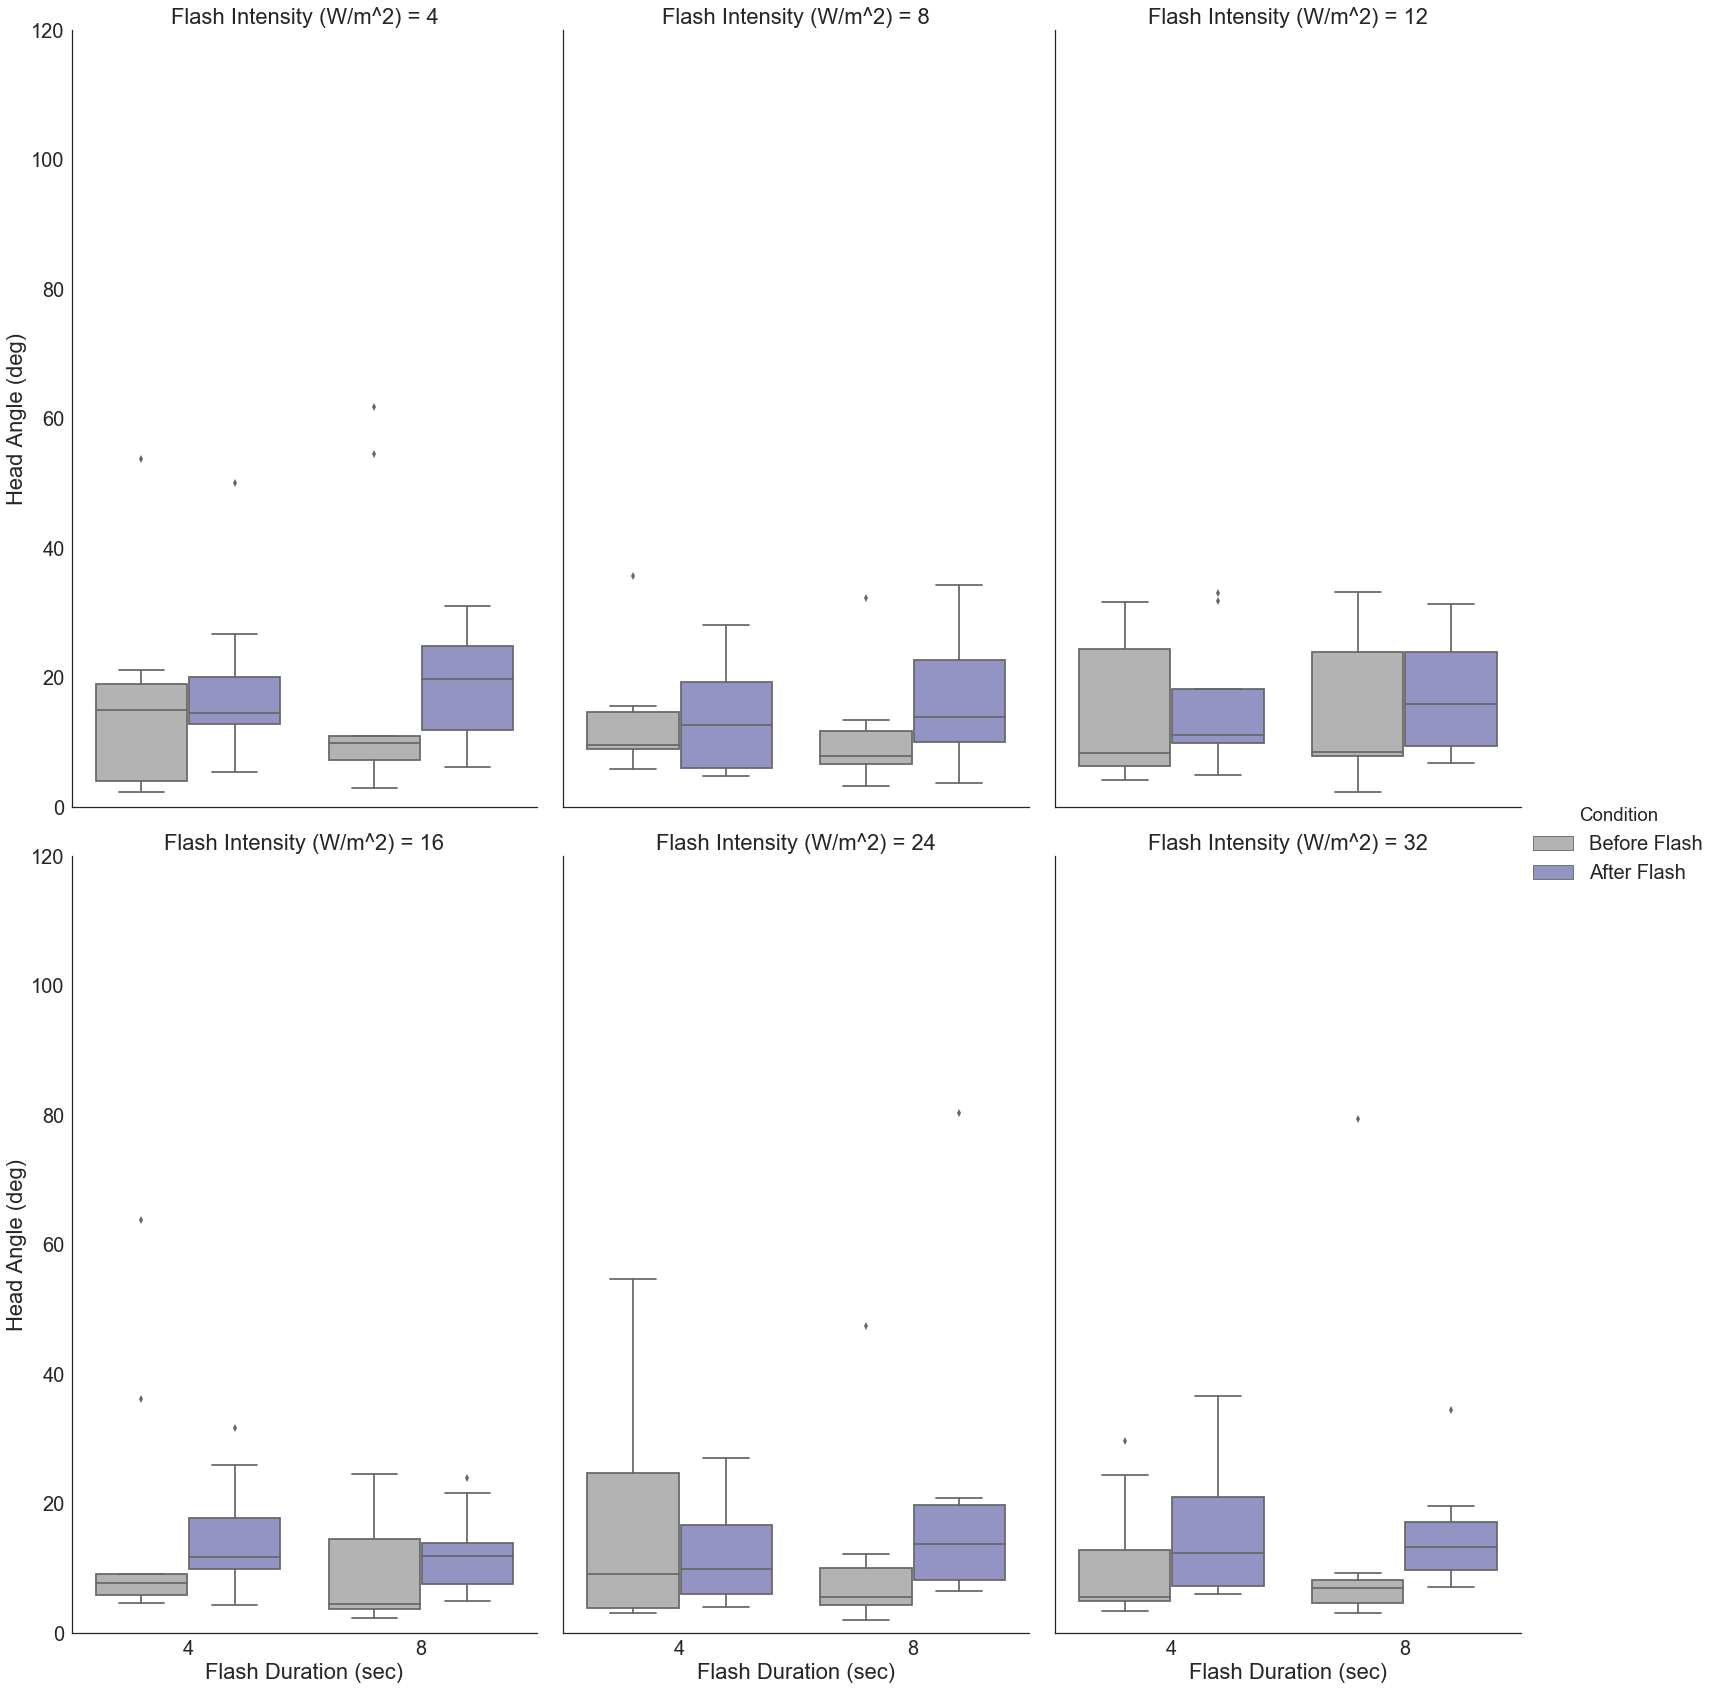

In [18]:
sns.set_context("notebook", font_scale=2)
sns.set_style("white")
g = sns.factorplot(x="Flash Duration (sec)", y="Head Angle (deg)",
                   hue="Condition", col="Flash Intensity (W/m^2)", col_wrap=3,
                   data=mean_head_angle_before_after, kind="box", size=12, aspect=.6,
                   palette={"Before Flash": [0.7, 0.7, 0.7], "After Flash": [0.55, 0.55, 0.8]});
plt.ylim(0, 120);
plt.savefig(os.path.join(fig_dir, "factor_plot_per_flash_intensity_head_angle_%s.png"%(experiment)))